## Домашняя работа по теме: "Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях"

Выполнила Моисеенкова Полина

__Задание:__
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.preprocessing import StandardScaler
import shap

f:\anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [2]:
df = pd.read_excel("default of credit card clients.xls", header=1)
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


**Описание датасета**

* **LIMIT_BAL** - Сумма предоставленного кредита
* **SEX** - Пол (1=мужчина, 2=женщина)
* **EDUCATION** - Образование (1=аспирантура, 2=университет, 3=старшая школа, 4=прочее, 5=неизвестно, 6=неизвестно)
* **MARRIAGE** - Семейное положение (1=женат/замужен, 2=не женат/не замуженм, 3=прочее)
* **AGE** - Возраст (в годах)
* **PAY_0** - Статус погашения в Сентябре (-1=погашен полностью, 0=погашен частично, 1=отсрочка платежа на один месяц, .., 3=отсрочка платежа на три месяца и более)
* **PAY_2** - Статус погашения в Августе
* **PAY_3** - Статус погашения в Июле
* **PAY_4** - Статус погашения в Июне
* **PAY_5** - Статус погашения в Мае
* **PAY_6** - Статус погашения в Апреле
* **BILL_AMT1** - Сумма выписки по счету в Сентябре
* **BILL_AMT2** - Сумма выписки по счету в Августе
* **BILL_AMT3** - Сумма выписки по счету в Июле
* **BILL_AMT4** - Сумма выписки по счету в Июне
* **BILL_AMT5** - Сумма выписки по счету в Мае
* **BILL_AMT6** - Сумма выписки по счету в Апреле
* **PAY_AMT1** - Сумма предыдущего платежа в Сентябре
* **PAY_AMT2** - Сумма предыдущего платежа в Августе
* **PAY_AMT3** - Сумма предыдущего платежа в Июле
* **PAY_AMT4** - Сумма предыдущего платежа в Июне
* **PAY_AMT5** - Сумма предыдущего платежа в Мае
* **PAY_AMT6** - Сумма предыдущего платежа в Апреле
* **default payment next month** - Просрочка платежа в следующем месяце (1=да, 0=нет)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

Переименуем некоторые поля

In [4]:
df = df.rename(columns={"PAY_0": "PAY_1", "default payment next month": "NEXT_MONTH_DEFAULT"})
df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


## Fitch Engineering

Проверим NULL значения в датасете

In [5]:
percentage_of_null_values = ((df.isnull().sum())*100/len(df)).sort_values(ascending = False)
percentage_of_null_values

ID                    0.0
BILL_AMT2             0.0
PAY_AMT6              0.0
PAY_AMT5              0.0
PAY_AMT4              0.0
PAY_AMT3              0.0
PAY_AMT2              0.0
PAY_AMT1              0.0
BILL_AMT6             0.0
BILL_AMT5             0.0
BILL_AMT4             0.0
BILL_AMT3             0.0
BILL_AMT1             0.0
LIMIT_BAL             0.0
PAY_6                 0.0
PAY_5                 0.0
PAY_4                 0.0
PAY_3                 0.0
PAY_2                 0.0
PAY_1                 0.0
AGE                   0.0
MARRIAGE              0.0
EDUCATION             0.0
SEX                   0.0
NEXT_MONTH_DEFAULT    0.0
dtype: float64

NULL значений не имеется

Посмотрим на распределение предоставленного кредита

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Count'>

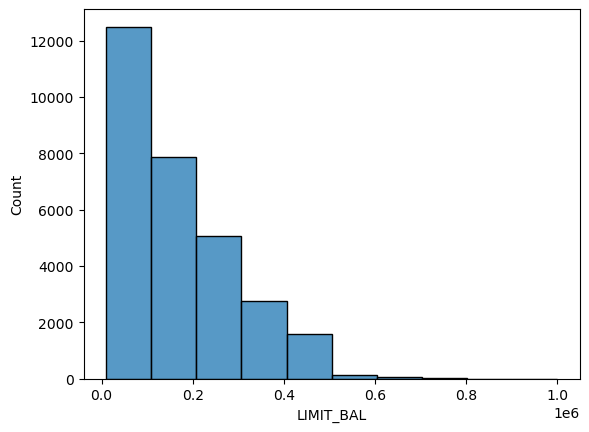

In [6]:
sns.histplot(df['LIMIT_BAL'], bins=10)

Заменим значения в поле SEX

In [7]:
df['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [8]:
df['SEX'] = df['SEX'].map({1: 1, 2: 0})
df['SEX'].value_counts()

0    18112
1    11888
Name: SEX, dtype: int64

Посмотрим на поля MARRIAGE и EDUCATION

In [9]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

По описанию "Семейное положение (1=женат/замужен, 2=не женат/не замуженм, 3=прочее)", поэтому переименуем значения

In [10]:
df['MARRIAGE'] = df['MARRIAGE'].map({0: 'other', 
                                     1: 'married',
                                     2: 'single',
                                     3: 'other'})
df['MARRIAGE'].value_counts()

single     15964
married    13659
other        377
Name: MARRIAGE, dtype: int64

In [11]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

По описанию "Образование (1=аспирантура, 2=университет, 3=старшая школа, 4=прочее, 5=неизвестно, 6=неизвестно)", переименуем значения

In [12]:
df['EDUCATION'] = df['EDUCATION'].map({0: 'other',
                                       1: 'graduate_school',
                                       2: 'university',
                                       3: 'high_school',
                                       4: 'other',
                                       5: 'other',
                                       6: 'other'})

df['EDUCATION'].value_counts()

university         14030
graduate_school    10585
high_school         4917
other                468
Name: EDUCATION, dtype: int64

Посмотрим на значения PAY_1 ... PAY_6

In [13]:
df['PAY_1'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

По описанию "Статус погашения в Сентябре (-1=погашен полностью, 0=погашен частично, 1=отсрочка платежа на один месяц, .., 3=отсрочка платежа на три месяца и более)"

У нас имеется значение "-2", заменим его на "-1". Сделаем так со всеми полями PAY_1 ... PAY_6

In [14]:
payments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in payments:
    df[col] = df[col].replace(-2, -1)

In [15]:
df['PAY_1'].value_counts()

 0    14737
-1     8445
 1     3688
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

Посмотрим на распределение целевой переменной

In [16]:
df['NEXT_MONTH_DEFAULT'].value_counts()

0    23364
1     6636
Name: NEXT_MONTH_DEFAULT, dtype: int64

Присутсвует явный дисбаланс классов. Напишем функцию для балансировки

In [17]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Разделим признаки на категориальные и числовые

In [18]:
cat_features = ['EDUCATION', 'MARRIAGE']
num_features = ['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bin_features = ['SEX']

Стандартизация данных

In [19]:
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])


In [20]:
for col in cat_features:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)

df.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT5,PAY_AMT6,NEXT_MONTH_DEFAULT,EDUCATION_graduate_school,EDUCATION_high_school,EDUCATION_other,EDUCATION_university,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,1,-1.136720,0,university,married,-1.246020,1.942687,1.938346,-0.946291,-0.936042,...,-0.314136,-0.293382,1,0,0,0,1,1,0,0
1,2,-0.365981,0,university,single,-1.029047,-1.085297,1.938346,0.029300,0.076698,...,-0.314136,-0.180878,1,0,0,0,1,0,0,1


In [21]:
all_feautures = [col for col in df.columns if col not in cat_features
                 and col != 'ID' and col != 'NEXT_MONTH_DEFAULT']
all_feautures

['LIMIT_BAL',
 'SEX',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'EDUCATION_graduate_school',
 'EDUCATION_high_school',
 'EDUCATION_other',
 'EDUCATION_university',
 'MARRIAGE_married',
 'MARRIAGE_other',
 'MARRIAGE_single']

In [22]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[all_feautures], df['NEXT_MONTH_DEFAULT'], random_state=42)

Балансировка целевой переменной

In [23]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'NEXT_MONTH_DEFAULT')
    
df_balanced['NEXT_MONTH_DEFAULT'].value_counts()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


0    17491
1    15027
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [24]:
X_train = df_balanced.drop(columns='NEXT_MONTH_DEFAULT')
y_train = df_balanced['NEXT_MONTH_DEFAULT']

Построим классифакатор на основе LightGBM

In [25]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[100,:], X_train.iloc[100,:])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Из графика видно, почему модель приняла решение о том, что клиент НЕ просрочит с выплатой по кредиту в следующем месяце. Большой вес в пользу такого решения имеет признак PAY_1. Клиент заплатил вовремя в первый месяц. Еще существенный вклад вносит признак LIMIT_BAL, у клиента большая сумма кредита.

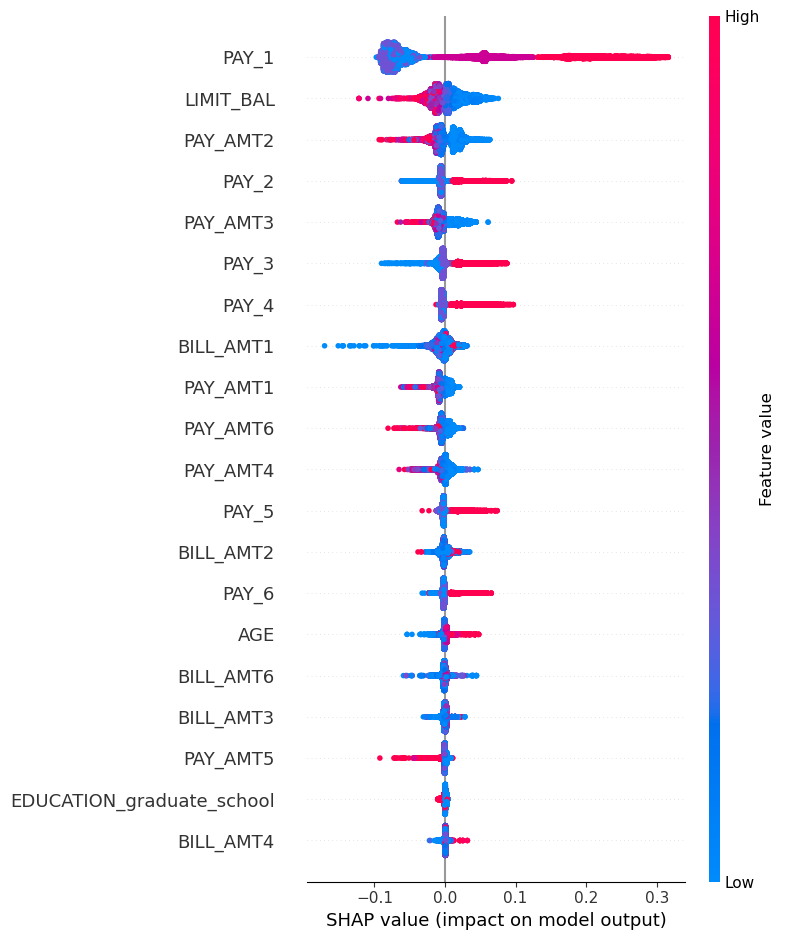

In [26]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X_train)

Из графиков видно, чем больше просрочка по платежу за первый месяц, тем больше вклад это приносит в решение, что клиент просрочит с платежом в следующем месяце.
И чем больше сумма кредита, тем меньше это вносит вклад в то, что клиент просрочит с выплатой.

Посмотрим на влияние каждого признака

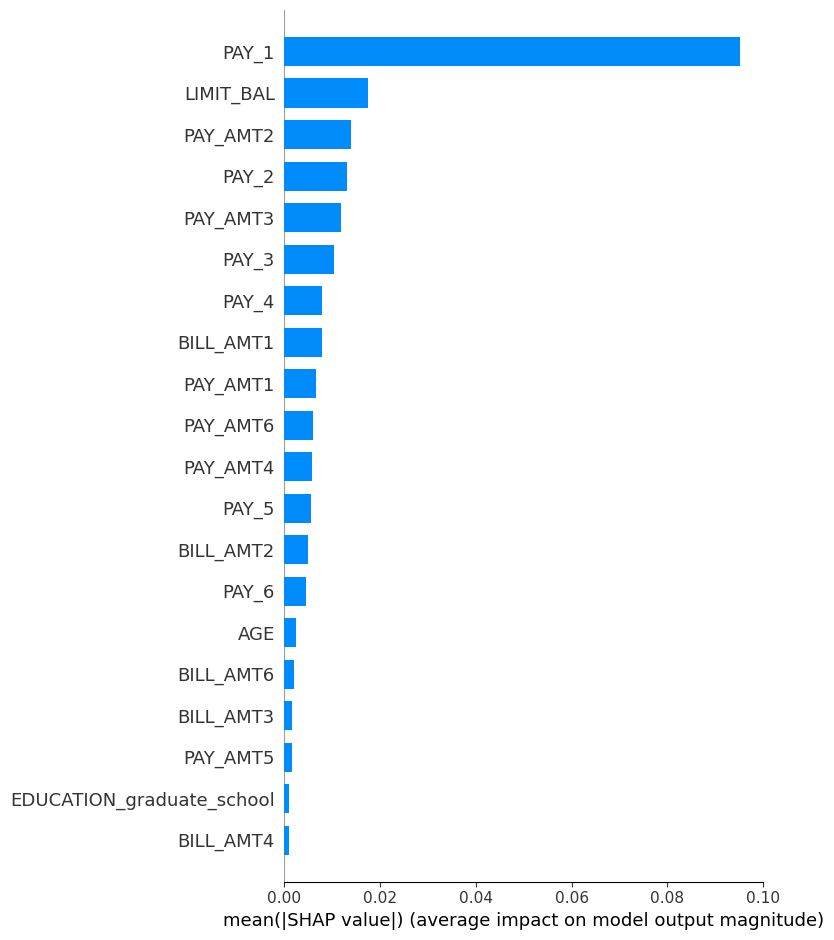

In [27]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

Из графика видно, что наибольшими весами обладают признаки PAY_1 и LIMIT_BAL.